In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.metric.metric import NormStability, NSbuilder, Stability, ProgressiveError
from UnarySim.sw.stream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.kernel.div import UnaryDiv
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker, cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import time
import math
import numpy as np
import seaborn as sns
from tqdm import tqdm

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [4]:
def test(
    rng="Sobol", 
    total_cnt=100, 
    mode="unipolar", 
    bitwidth=8, 
    threshold=0.05
):
    ns_val=[0.25, 0.5, 0.75]
    stype = torch.float
    rtype = torch.float
    
    pbar = tqdm(total=3*total_cnt*(2**bitwidth))
    if mode is "unipolar":
        # all values in unipolar are non-negative
        low_bound = 0
        up_bound = 2**bitwidth
    elif mode is "bipolar":
        # values in bipolar are arbitrarily positive or negative
        low_bound = -2**(bitwidth-1)
        up_bound = 2**(bitwidth-1)

    # input0 is dividend
    input0 = []
    input1 = []
    for dim_y in range(up_bound, low_bound-1, -1):
        input0.append([])
        input1.append([])
        for dim_x in range(low_bound, up_bound+1, 1):
            input0[up_bound-dim_y].append(dim_y)
            input1[up_bound-dim_y].append(dim_x)

    input0 = torch.tensor(input0, dtype=torch.float).div(up_bound).to(device)
    input1 = torch.tensor(input1, dtype=torch.float).div(up_bound).to(device)
    output = (input1/input0).to(device)
    
    # find the invalid postions in quotient
    output_nan = torch.isnan(output)
    output_inf = torch.isinf(output)
    output_mask = output_nan + output_inf
    output[output_mask] = 0
    output = output.clamp(-1, 1)
    
    for ns in ns_val:
        print("# # # # # # # # # # # # # # # # # #")
        print("Target normstab:", ns)
        print("# # # # # # # # # # # # # # # # # #")

        result_ns_total = []
        input_ns_total = []
        output_ns_total = []

        for rand_idx in range(1, total_cnt+1):
            outputNS = NormStability(output, mode=mode, threshold=threshold).to(device)

            input0NS = NormStability(input0, mode=mode, threshold=threshold).to(device)
            input1NS = NormStability(input1, mode=mode, threshold=threshold).to(device)

            dut = UnaryDiv(depth_abs=3, 
                           depth_kernel=2, 
                           depth_sync=2, 
                           shiftreg_abs=False, 
                           mode=mode, 
                           rng=rng, 
                           rng_dim=4).to(device)

            input0BSGen = NSbuilder(bitwidth=bitwidth, 
                                    mode=mode, 
                                    normstability=ns, 
                                    threshold=threshold, 
                                    value=input0, 
                                    rng_dim=rand_idx).to(device)
            
            input1BSGen = NSbuilder(bitwidth=bitwidth, 
                                    mode=mode, 
                                    normstability=ns, 
                                    threshold=threshold, 
                                    value=input1, 
                                    rng_dim=rand_idx+1).to(device)

            start_time = time.time()
            with torch.no_grad():
                for i in range(2**bitwidth):
                    input0_bs = input0BSGen()
                    input1_bs = input1BSGen()

                    input0NS.Monitor(input0_bs)
                    input1NS.Monitor(input1_bs)

                    output_bs = dut(input1_bs, input0_bs)
                    outputNS.Monitor(output_bs)
                    pbar.update(1)

            # get the result for different rng
            input0_ns = input0NS()
            input1_ns = input1NS()
            input_ns = (input0_ns + input1_ns)/2
            output_ns = outputNS()
    
            result_ns = (output_ns/input_ns).clamp(0, 1).cpu().numpy()
            result_ns[output_mask.cpu().numpy()] = np.nan
            result_ns_total.append(result_ns)
            input_ns = input_ns.cpu().numpy()
            input_ns[output_mask.cpu().numpy()] = np.nan
            input_ns_total.append(input_ns)
            output_ns = output_ns.cpu().numpy()
            output_ns[output_mask.cpu().numpy()] = np.nan
            output_ns_total.append(output_ns)
            # print("--- %s seconds ---" % (time.time() - start_time))

        # get the result for different rng
        result_ns_total = np.array(result_ns_total)
        input_ns_total = np.array(input_ns_total)
        output_ns_total = np.array(output_ns_total)
        #######################################################################
        # check the error of all simulation
        #######################################################################
        input_ns_total_no_nan = input_ns_total[~np.isnan(input_ns_total)]
        print("avg I NS:{:1.4}".format(np.mean(input_ns_total_no_nan)))
        print("max I NS:{:1.4}".format(np.max(input_ns_total_no_nan)))
        print("min I NS:{:1.4}".format(np.min(input_ns_total_no_nan)))
        print()
        output_ns_total_no_nan = output_ns_total[~np.isnan(output_ns_total)]
        print("avg O NS:{:1.4}".format(np.mean(output_ns_total_no_nan)))
        print("max O NS:{:1.4}".format(np.max(output_ns_total_no_nan)))
        print("min O NS:{:1.4}".format(np.min(output_ns_total_no_nan)))
        print()
        result_ns_total_no_nan = result_ns_total[~np.isnan(result_ns_total)]
        print("avg O/I NS:{:1.4}".format(np.mean(result_ns_total_no_nan)))
        print("max O/I NS:{:1.4}".format(np.max(result_ns_total_no_nan)))
        print("min O/I NS:{:1.4}".format(np.min(result_ns_total_no_nan)))
        print()

        #######################################################################
        # check the error according to input value
        #######################################################################
        avg_total = np.mean(result_ns_total, axis=0)
        avg_total[output_mask.cpu().numpy()] = 0
        fig, ax = plt.subplots()
        fig.set_size_inches(5.5, 4)
        axis_len = outputNS()[1].size()[0]
        y_axis = []
        x_axis = []
        for axis_index in range(axis_len):
            y_axis.append((up_bound-axis_index/(axis_len-1)*(up_bound-low_bound))/up_bound)
            x_axis.append((axis_index/(axis_len-1)*(up_bound-low_bound)+low_bound)/up_bound)
        X, Y = np.meshgrid(x_axis, y_axis)
        Z = avg_total
        levels = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        cs = plt.contourf(X, Y, Z, levels, cmap=cm.RdBu, extend="both")
        cbar = fig.colorbar(cs)

        # plt.tight_layout()
        plt.xticks(np.arange(low_bound/up_bound, up_bound/up_bound+0.1, step=0.5))
        # ax.xaxis.set_ticklabels([])
        plt.yticks(np.arange(low_bound/up_bound, up_bound/up_bound+0.1, step=0.5))
        # ax.yaxis.set_ticklabels([])

        plt.show()
        plt.close()
    pbar.close()

  0%|          | 0/76800 [00:00<?, ?it/s]

# # # # # # # # # # # # # # # # # #
Target normstab: 0.25
# # # # # # # # # # # # # # # # # #


 33%|███▎      | 25596/76800 [06:30<07:43, 110.47it/s]

avg I NS:0.3028
max I NS:1.0
min I NS:0.1797

avg O NS:0.4894
max O NS:1.0
min O NS:0.0

avg O/I NS:0.6755
max O/I NS:1.0
min O/I NS:0.0



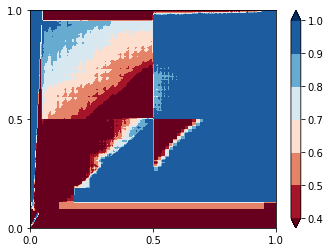

# # # # # # # # # # # # # # # # # #
Target normstab: 0.5
# # # # # # # # # # # # # # # # # #


 67%|██████▋   | 51198/76800 [12:52<03:18, 128.97it/s]

avg I NS:0.5022
max I NS:1.0
min I NS:0.3574

avg O NS:0.5478
max O NS:1.0
min O NS:0.0

avg O/I NS:0.7058
max O/I NS:1.0
min O/I NS:0.0



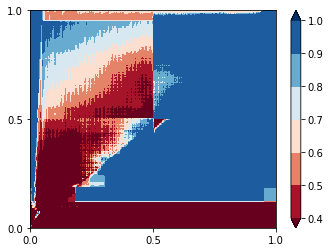

# # # # # # # # # # # # # # # # # #
Target normstab: 0.75
# # # # # # # # # # # # # # # # # #


100%|█████████▉| 76799/76800 [17:49<00:00, 147.08it/s]

avg I NS:0.6951
max I NS:1.0
min I NS:0.543

avg O NS:0.5934
max O NS:1.0
min O NS:0.0

avg O/I NS:0.7097
max O/I NS:1.0
min O/I NS:0.0



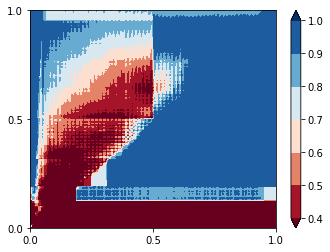

100%|██████████| 76800/76800 [17:50<00:00, 71.73it/s] 


In [5]:
test(rng="Sobol", total_cnt=100, mode="unipolar", bitwidth=8, threshold=0.05)